2025-08-21 10:34:30.220609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755772470.558309      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755772470.653269      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Data split done.
Train images: 9429
Test images: 2361
Found 9429 images belonging to 9 classes.
Found 2361 images belonging to 9 classes.
Found 9429 images belonging to 9 classes.
Classes: 9, steps_per_epoch: 295, val_steps: 74


I0000 00:00:1755772669.386822      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755772669.387643      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1755772695.864341     123 service.cc:148] XLA service 0x78ca680027c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755772695.866196     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755772695.866220     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755772698.926809     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755772711.418786     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 - 303s - 1s/step - accuracy: 0.5854 - loss: 1.2248 - val_accuracy: 0.7471 - val_loss: 0.7322
Epoch 2/30
295/295 - 232s - 788ms/step - accuracy: 0.7726 - loss: 0.6686 - val_accuracy: 0.8272 - val_loss: 0.5001
Epoch 3/30
295/295 - 235s - 796ms/step - accuracy: 0.8129 - loss: 0.5303 - val_accuracy: 0.8835 - val_loss: 0.3530
Epoch 4/30
295/295 - 232s - 785ms/step - accuracy: 0.8483 - loss: 0.4333 - val_accuracy: 0.9051 - val_loss: 0.3014
Epoch 5/30
295/295 - 229s - 776ms/step - accuracy: 0.8584 - loss: 0.3967 - val_accuracy: 0.9022 - val_loss: 0.2918
Epoch 6/30
295/295 - 228s - 774ms/step - accuracy: 0.8601 - loss: 0.3897 - val_accuracy: 0.8920 - val_loss: 0.3201
Epoch 7/30
295/295 - 229s - 776ms/step - accuracy: 0.8740 - loss: 0.3614 - val_accuracy: 0.9094 - val_loss: 0.2621
Epoch 8/30
295/295 - 224s - 760ms/step - accuracy: 0.9013 - loss: 0.2941 - val_accuracy: 0.9305 - val_loss: 0.2040
Epoch 9/30
295/295 - 227s - 771ms/step - accuracy: 0.9096 - loss: 0.2696 - val_accuracy: 0.928

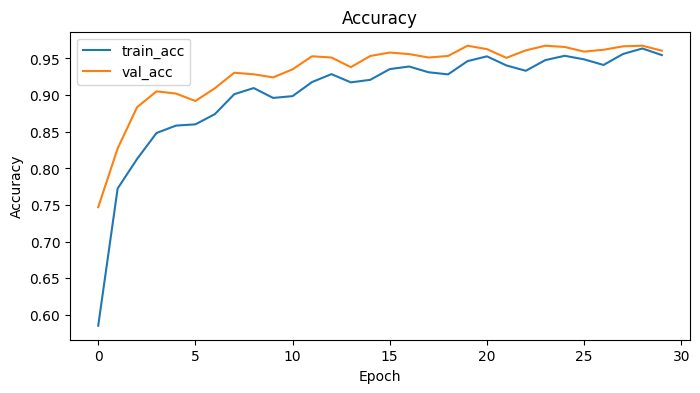

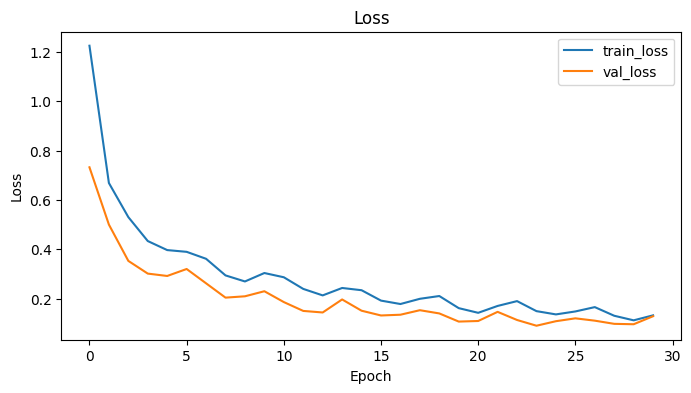

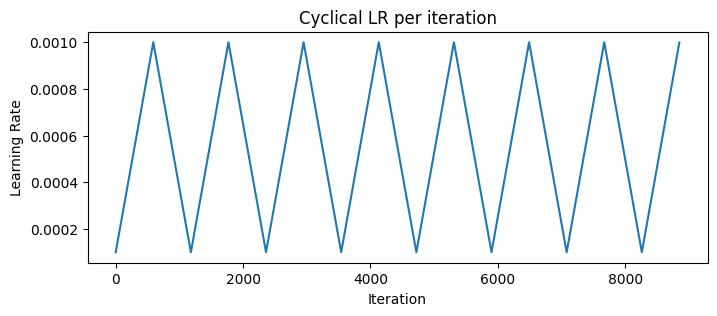

74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 486ms/step


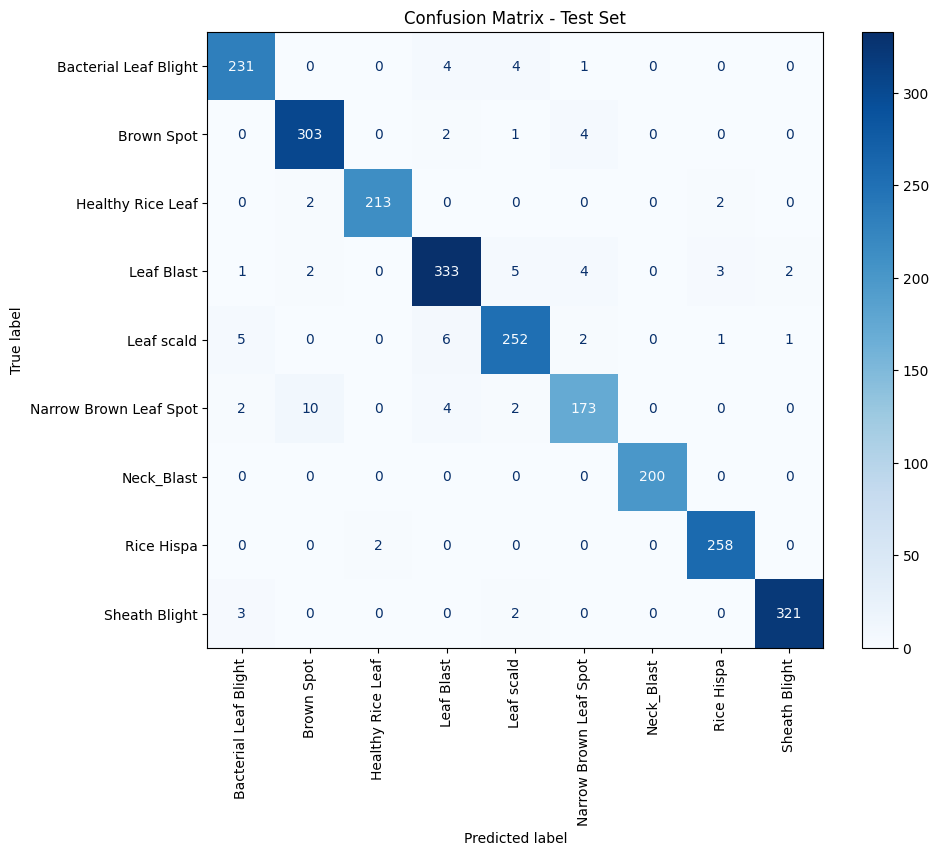

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


295/295 ━━━━━━━━━━━━━━━━━━━━ 105s 356ms/step


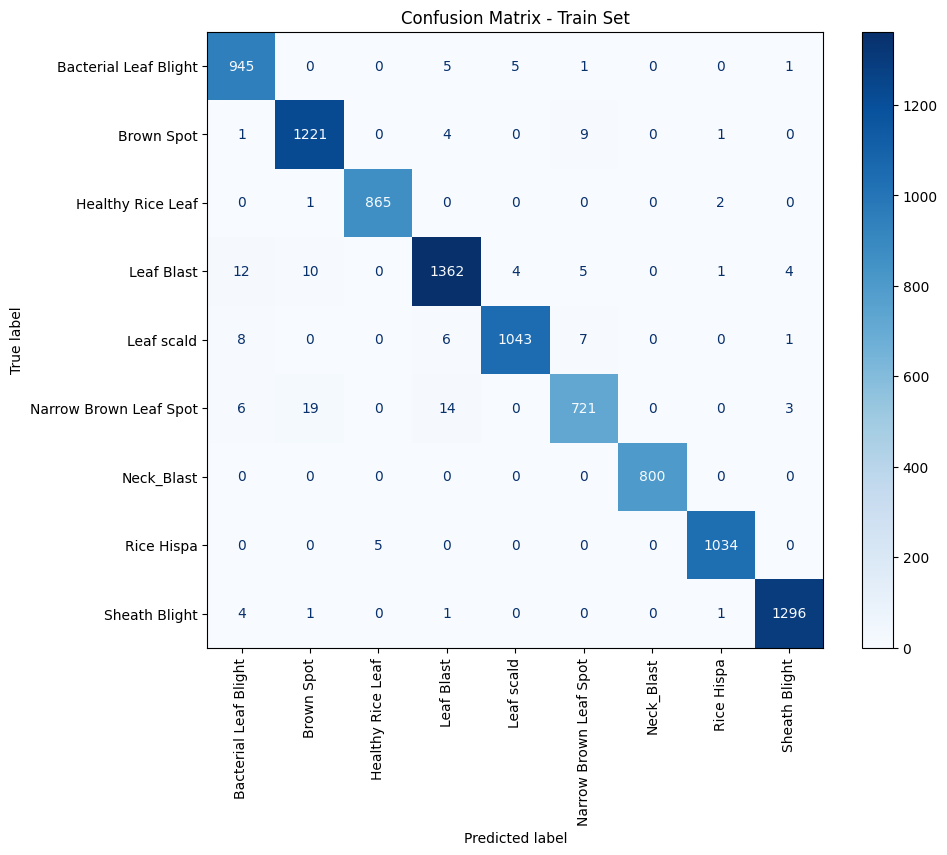

Saved model -> my_dl_model.h5


In [1]:
# full_train_script.py
import os
import shutil
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

# -------------------------
# Config / reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

SOURCE_DIR = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG'  # change as needed
TRAIN_DIR = '/kaggle/working/train'
TEST_DIR = '/kaggle/working/test'
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# -------------------------
# Data split (20% test)
# -------------------------
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=SEED, shuffle=True)

    train_cdir = os.path.join(TRAIN_DIR, class_name)
    test_cdir = os.path.join(TEST_DIR, class_name)
    os.makedirs(train_cdir, exist_ok=True)
    os.makedirs(test_cdir, exist_ok=True)

    for f in train_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(train_cdir, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    for f in test_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(test_cdir, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("Data split done.")
print("Train images:", sum(len(os.listdir(os.path.join(TRAIN_DIR, d))) for d in os.listdir(TRAIN_DIR)))
print("Test images:", sum(len(os.listdir(os.path.join(TEST_DIR, d))) for d in os.listdir(TEST_DIR)))

# -------------------------
# Hyperparameters
# -------------------------
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
INITIAL_LR = 1e-4
MAX_LR = 1e-3
EPOCHS = 30

# -------------------------
# Generators
# -------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED
)

test_ds = eval_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# generator over train data but not shuffled for evaluation
train_eval_ds = eval_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(train_ds.class_indices)
STEPS_PER_EPOCH = len(train_ds)
VALIDATION_STEPS = len(test_ds)
print(f"Classes: {NUM_CLASSES}, steps_per_epoch: {STEPS_PER_EPOCH}, val_steps: {VALIDATION_STEPS}")

# -------------------------
# Model
# -------------------------
base = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# -------------------------
# Robust per-iteration Cyclical LR callback
# -------------------------
class CyclicLR(keras.callbacks.Callback):
    """
    Triangular CLR (per-iteration). step_size is half-cycle length in iterations.
    """
    def __init__(self, base_lr, max_lr, step_size, verbose=0):
        super().__init__()
        self.base_lr = float(base_lr)
        self.max_lr = float(max_lr)
        self.step_size = float(step_size)
        self.iterations = 0.0
        self.history = {'lr': []}
        self.verbose = verbose

    def clr(self):
        cycle = np.floor(1 + self.iterations / (2.0 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2.0 * cycle + 1.0)
        scale = max(0.0, (1.0 - x))
        return self.base_lr + (self.max_lr - self.base_lr) * scale

    def _set_optimizer_lr(self, lr_value):
        opt = self.model.optimizer
        # Try assign then fallback to set_value
        try:
            opt.learning_rate.assign(lr_value)
        except Exception:
            tf.keras.backend.set_value(opt.learning_rate, lr_value)

    def on_train_begin(self, logs=None):
        self.iterations = 0.0
        self.history = {'lr': []}
        self._set_optimizer_lr(self.base_lr)

    def on_train_batch_begin(self, batch, logs=None):
        lr = float(self.clr())
        self._set_optimizer_lr(lr)
        self.history['lr'].append(lr)
        if self.verbose and (len(self.history['lr']) % 500 == 0):
            print(f"[CLR] iter {int(self.iterations)} lr={lr:.6f}")

    def on_train_batch_end(self, batch, logs=None):
        self.iterations += 1.0

# set step_size in iterations (half-cycle). example uses half-cycle spanning 2 epochs:
step_size_iters = 2 * STEPS_PER_EPOCH
clr_cb = CyclicLR(base_lr=INITIAL_LR, max_lr=MAX_LR, step_size=step_size_iters, verbose=0)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# -------------------------
# Compile & fit
# -------------------------
opt = Adam(learning_rate=INITIAL_LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[clr_cb, early_stop],
    verbose=2
)

# -------------------------
# Plots: accuracy / loss / lr
# -------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(clr_cb.history['lr'])
plt.title('Cyclical LR per iteration')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.show()

# -------------------------
# Confusion matrices
# -------------------------
# Test set
test_ds.reset()
pred_probs = model.predict(test_ds, steps=VALIDATION_STEPS, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_ds.classes
idx_to_class = {v:k for k,v in test_ds.class_indices.items()}
labels_ordered = [idx_to_class[i] for i in range(NUM_CLASSES)]
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_ordered)
plt.figure(figsize=(10,8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=plt.gca())
plt.title('Confusion Matrix - Test Set')
plt.show()

# Train set (non-shuffled)
train_eval_ds.reset()
pred_probs_train = model.predict(train_eval_ds, steps=len(train_eval_ds), verbose=1)
pred_labels_train = np.argmax(pred_probs_train, axis=1)
true_labels_train = train_eval_ds.classes
idx_to_class_train = {v:k for k,v in train_eval_ds.class_indices.items()}
labels_ordered_train = [idx_to_class_train[i] for i in range(NUM_CLASSES)]
cm_train = confusion_matrix(true_labels_train, pred_labels_train)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels_ordered_train)
plt.figure(figsize=(10,8))
disp2.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=plt.gca())
plt.title('Confusion Matrix - Train Set')
plt.show()

# -------------------------
# Save model
# -------------------------
model.save('my_dl_model.h5')
print("Saved model -> my_dl_model.h5")

# -------------------------
# Optional: fine-tune top layers (uncomment to use)
# -------------------------
# base.trainable = True
# for layer in base.layers[:-20]:
#     layer.trainable = False
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_ds, epochs=10, validation_data=test_ds, steps_per_epoch=len(train_ds), validation_steps=len(test_ds), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
# model.save('my_dl_model_finetuned.h5')

In [2]:
from sklearn.metrics import classification_report

# -------------------------
# Classification report (Test set)
# -------------------------
print("\nClassification Report - Test Set")
print(classification_report(true_labels, pred_labels, target_names=labels_ordered, digits=4))

# -------------------------
# Classification report (Train set)
# -------------------------
print("\nClassification Report - Train Set")
print(classification_report(true_labels_train, pred_labels_train, target_names=labels_ordered_train, digits=4))



Classification Report - Test Set
                        precision    recall  f1-score   support

 Bacterial Leaf Blight     0.9545    0.9625    0.9585       240
            Brown Spot     0.9558    0.9774    0.9665       310
     Healthy Rice Leaf     0.9907    0.9816    0.9861       217
            Leaf Blast     0.9542    0.9514    0.9528       350
            Leaf scald     0.9474    0.9438    0.9456       267
Narrow Brown Leaf Spot     0.9402    0.9058    0.9227       191
            Neck_Blast     1.0000    1.0000    1.0000       200
            Rice Hispa     0.9773    0.9923    0.9847       260
         Sheath Blight     0.9907    0.9847    0.9877       326

              accuracy                         0.9674      2361
             macro avg     0.9679    0.9666    0.9672      2361
          weighted avg     0.9674    0.9674    0.9673      2361


Classification Report - Train Set
                        precision    recall  f1-score   support

 Bacterial Leaf Blight     0.96

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -------------------------
# Overall metrics (Test set)
# -------------------------
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='weighted')
rec = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nOverall Test Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")



Overall Test Metrics:
Accuracy  : 0.9674
Precision : 0.9674
Recall    : 0.9674
F1-score  : 0.9673


In [4]:
model.save('my_dl_model.h5')
print("Saved model -> my_dl_model.h5")


Saved model -> my_dl_model.h5
